In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import deepRD.tools.trajectoryTools as trajectoryTools
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [502]:
d1=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0001")).unsqueeze(0)
d2=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0002")).unsqueeze(0)
d3=torch.Tensor(trajectoryTools.loadTrajectory("simMoriZwanzig_", "0003")).unsqueeze(0)
# time, position (3d), velocity (3d), states (1d), r_aux(3d)
dataset = torch.cat((d1, d2, d3), dim=0)
dataset.shape

torch.Size([3, 10000, 11])

In [503]:
# Number of datasets for training
n_datasets = dataset.shape[0]

# Reform data for input
r_aux = dataset[:, :, -3:]
r_nxt = torch.roll(r_aux, -1, 1)
v = dataset[:, :, 4:7]
r_v = torch.cat((r_aux, v), dim = 2)

# Remove last datapoint for consistency
r_aux = r_aux[:, :-1]
r_nxt = r_nxt[:, :-1]
v = v[:, :-1]
r_v = r_v[:, :-1]
# Input: R_n+1 (3), condition: r_n, velocity_n (6)
inputs = torch.cat(tuple([r_nxt[i] for i in range(n_datasets)]), dim=0)
labels = torch.cat(tuple([r_v[i] for i in range(n_datasets)]), dim=0)
data = torch.utils.data.TensorDataset(inputs, labels)
r_aux.shape, r_nxt.shape, v.shape, r_v.shape, inputs.shape, labels.shape, r_aux[0, :3], r_nxt[0, :3], v[0, :3], r_v[0, :3]

(torch.Size([3, 9999, 3]),
 torch.Size([3, 9999, 3]),
 torch.Size([3, 9999, 3]),
 torch.Size([3, 9999, 6]),
 torch.Size([29997, 3]),
 torch.Size([29997, 6]),
 tensor([[-0.0051, -0.0105, -0.0113],
         [-0.0117, -0.0048,  0.0076],
         [-0.0024,  0.0068,  0.0205]]),
 tensor([[-0.0117, -0.0048,  0.0076],
         [-0.0024,  0.0068,  0.0205],
         [-0.0042,  0.0036,  0.0133]]),
 tensor([[ 0.1222, -0.1175, -0.4897],
         [ 0.1117, -0.1214, -0.4811],
         [ 0.1104, -0.1136, -0.4596]]),
 tensor([[-0.0051, -0.0105, -0.0113,  0.1222, -0.1175, -0.4897],
         [-0.0117, -0.0048,  0.0076,  0.1117, -0.1214, -0.4811],
         [-0.0024,  0.0068,  0.0205,  0.1104, -0.1136, -0.4596]]))

In [585]:
class VarAutoencoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3+6, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims+6, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )
        self.linear1 = nn.Linear(20, latent_dims)
        self.linear2 = nn.Linear(20, latent_dims)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def sample(self, label, num_samples=1):
        mean = [0.9080, 0.3038]
        std = [0.4723, 0.6708]
        x_g = torch.normal(mean[0], std[0], (num_samples,1))
        y_g = torch.normal(mean[1], std[1], (num_samples,1))
        z = torch.cat( (x_g, y_g), dim=1 )
        z_cond = torch.cat((z, label), dim=1)
        return self.decoder(z_cond)

    def forward(self, x, y, return_latent=False):
        x_cond = torch.cat((x,y), dim=1)
        x = self.encoder(x_cond)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        z_cond = torch.cat((z, y), dim=1)
        output = self.decoder(z_cond)
        if return_latent==True:
            return output, mu, logvar, z
        return output, mu, logvar

In [586]:
loss_1 = nn.MSELoss()
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [587]:
#optimizer = torch.optim.SGD(ae.parameters(), lr=learning_rate, momentum=momentum)

data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

In [588]:
x1, l1 = next(iter(data_loader))
print(x1.shape, l1.shape)

torch.Size([32, 3]) torch.Size([32, 6])


In [589]:
learning_rate = 1e-4
batch_size = 32
beta1 = 10
beta2 = 1e-4
data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)
VAE = VarAutoencoder(2)
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)

In [590]:
epochs = 20
losses = []
r_norms = None
r_new = None
for epoch in range(epochs):
    VAE.train()
    r_epoch = None
    for (image, label) in data_loader:

        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        l1 = loss_1(reconstruction, image)
        l2 = loss_2(mu, logvar)
        loss = beta1*l1 + beta2*l2
        losses.append([loss.item(), l1.item(), l2.item()])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            if r_epoch is None:
                r_epoch = reconstruction
            else:
                r_epoch = torch.cat( (r_epoch, reconstruction), dim=0)
                
            if epoch==epochs-1:
                norms = torch.cat( (torch.norm(image, dim=1).unsqueeze(0), torch.norm(reconstruction, dim=1).unsqueeze(0)) , dim=0)
                if r_norms is None:
                    r_norms = norms
                else:
                    r_norms = torch.cat((r_norms, norms), dim=1)
                    
    if r_new is None:
        r_new = r_epoch.unsqueeze(0)
    else:
        r_new = torch.cat( (r_new, r_epoch.unsqueeze(0)), dim=0) 
                
    print(f'E{epoch+1}:',round(losses[-1][0]*1000,4), round(losses[-1][1]*1000*beta1,4), round(losses[-1][2]*1000*beta2,4))


E1: 0.2376 0.2369 0.0006
E2: 0.2742 0.2736 0.0006
E3: 0.2503 0.2464 0.0039
E4: 0.2096 0.1922 0.0174
E5: 0.2897 0.2185 0.0712


KeyboardInterrupt: 

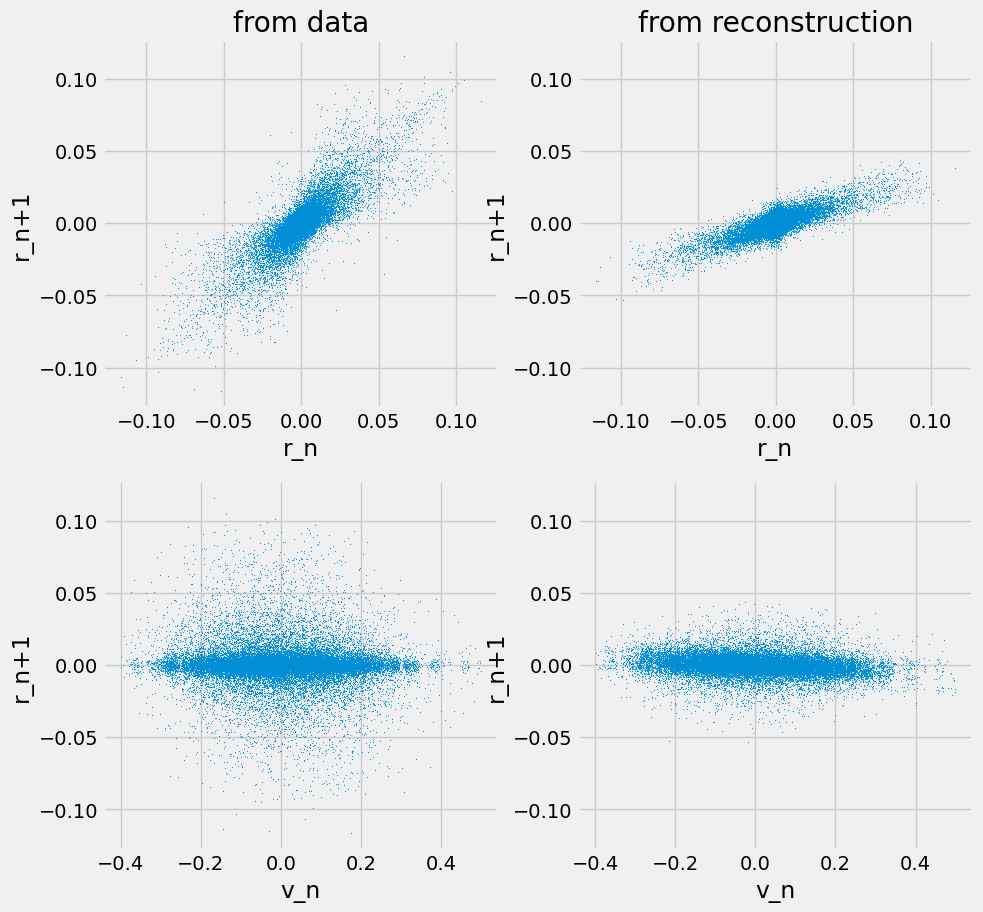

In [591]:
fig = plt.figure(figsize=(10,10))
#print(r_new[-1, :, 0].shape, torch.flatten(r_aux, end_dim=1)[:, 0].shape)

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(torch.flatten(r_aux,end_dim=1)[:, 0], torch.flatten(r_nxt, end_dim=1)[:,0], s=0.1)
ax1.set_xlabel('r_n')
ax1.set_ylabel('r_n+1')
ax1.set_title('from data')

ax2 = fig.add_subplot(2,2,2, sharey=ax1)
ax2.scatter(torch.flatten(r_aux, end_dim=1)[:,0], r_new[-1, :, 0], s=0.1)
#ax2.scatter(torch.flatten(r_aux, end_dim=1)[:,1], r_new[-1, :, 1], s=0.1)
ax2.set_xlabel('r_n')
ax2.set_ylabel('r_n+1')
ax2.set_title('from reconstruction')

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(torch.flatten(v,end_dim=1)[:, 0], torch.flatten(r_nxt, end_dim=1)[:,0], s=0.1)
ax3.set_xlabel('v_n')
ax3.set_ylabel('r_n+1')

ax4 = fig.add_subplot(2,2,4, sharey=ax3)
ax4.scatter(torch.flatten(v,end_dim=1)[:, 0], r_new[-1, :, 0], s=0.1)
ax4.set_xlabel('v_n')
ax4.set_ylabel('r_n+1')
fig.show()

In [583]:
r_ns = r_norms.clone().detach()
plt.scatter(r_ns[0], r_ns[1], s=1)
plt.xlabel('|r^n+1| real')
plt.ylabel('|r^n+1| reconstructed')
#plt.gca().set_aspect('equal')
plt.show()

AttributeError: 'NoneType' object has no attribute 'clone'

29997
tensor([0.5695, 0.1770]) tensor([0.5918, 0.4410])


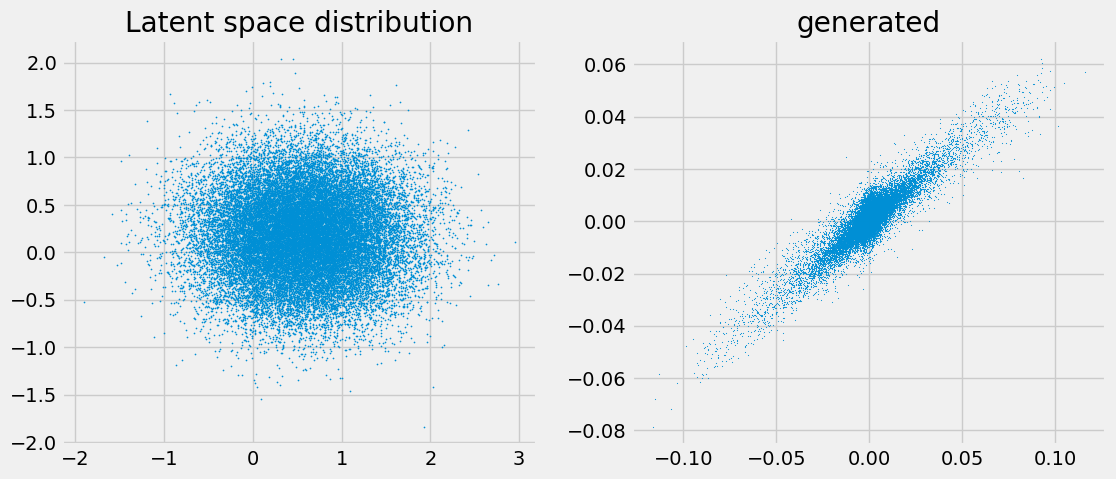

In [592]:
ind = numpy.random.choice(len(data), 29997)
labels = data[:][1]
print(len(labels))
with torch.no_grad():
    _, _, _, z = VAE(data[ind][0], data[ind][1], return_latent=True)
    generated = VAE.sample(labels, num_samples=len(labels))
mu = torch.mean(z,0)
std = torch.std(z,0)
print(mu, std)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(z[:, 0], z[:, 1], s=0.5)
ax1.set_title('Latent space distribution')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(torch.flatten(r_aux,end_dim=1)[:, 0], generated[:, 0], s=0.1)
ax2.set_title('generated')
fig.show()

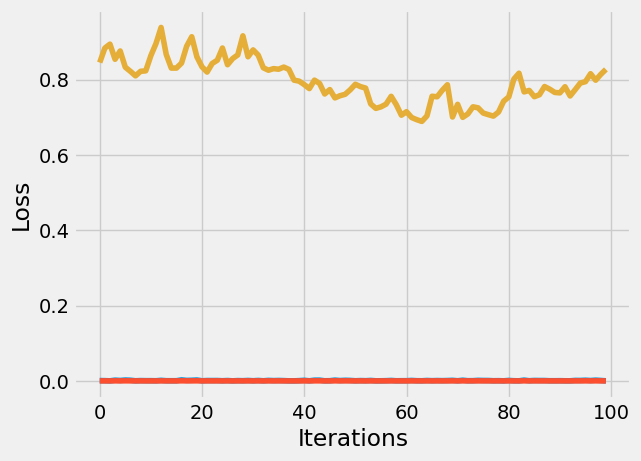

In [557]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.show()

In [558]:
# Save model parameters
torch.save(VAE.state_dict(), 'model_state.pt')